In [1]:
import numpy as np
from scipy import signal
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
import random

In [2]:
!pwd

/home/aj487/project/purity-monitor


In [3]:
import os
os.chdir('Jupyter/SiPM/')

In [4]:
import matplotlib.pyplot as plt
plt.style.use('../../style.mplstyle')
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
import sys
sys.path.insert(0, '../../../purity-monitor/')
sys.path.insert(0, '../../WaveformAnalysis/')

In [6]:
import Dataset as Dataset
import Waveform as Waveform
import SiPM as SiPM

In [7]:
import importlib
importlib.reload(Dataset)
importlib.reload(SiPM)

<module 'SiPM' from '../../../purity-monitor/SiPM.py'>

In [8]:
def gauss(x,mu=0,sigma=0.1):
    x = x-mu
    return np.exp(-np.square((x-mu)/sigma)/2)/(sigma*np.sqrt(2*np.pi))

In [9]:
D0 = SiPM.SiPM(Path='/project/david_moore/aj487/Data_WL110/LXe_Setup/TPC/20211119/', 
                    Selection='*DCR*.h5')
D0.Ch = [Waveform.Waveform(ID=x, Pol=1) for x in range(1,3)]

print(len(D0.Files))
for File in D0.Files[:1]:
    D0.ImportDataFromHDF5(File, D0.Ch)

433


In [10]:
time = D0.Ch[0].Time
desire_x = np.arange(-500,500,time[1]-time[0])
desire_y = gauss(desire_x)
resp_x = np.arange(0,1000,time[1]-time[0])
resp_y = D0.func(resp_x, 0, 1, 1.83, 46.93, 0)

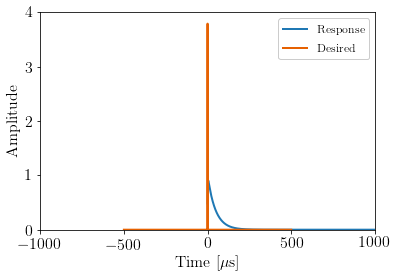

In [11]:
plt.figure()
plt.xlabel('Time [$\mu$s]')
plt.ylabel('Amplitude')
plt.xlim(-1000,1000)
plt.plot(resp_x, resp_y,label='Response')
plt.plot(desire_x, desire_y,label='Desired')
plt.legend(loc='upper right')
plt.show()

In [12]:
resp_f = np.fft.fft(resp_y)
desire_f = np.fft.fft(desire_y)
filter_f = desire_f/resp_f
filter_y = np.real(np.fft.ifft(filter_f))

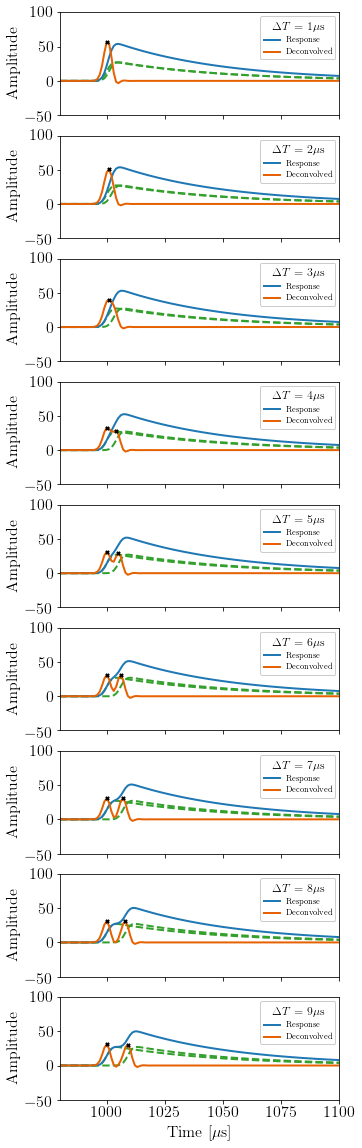

In [16]:
events = 2
new_x = np.arange(0, time[-1]-time[0], time[1]-time[0])
deltaT = 10

fig, ax = plt.subplots(figsize=(5,20), ncols=1,nrows=9,sharex=True,sharey=True,facecolor='white')

for i,deltaT in enumerate(np.arange(1,10,1)):
    ax[-1].set_xlabel('Time [$\mu$s]')
    ax[i].set_ylabel('Amplitude')
    ax[i].set_xlim(980,1100)

    times = [random.randint(1000,1000+deltaT) for x in range(events)]
    times = [1000, 1000+deltaT]
    ampl = [random.randint(1,5) for x in range(events)]
    ampl = [1 for x in range(events)]
    f_sing = [D0.func(new_x, 0, ampl[j]*30, 1.83, 46.93, times[j]) for j in range(events)]
    for k,f in enumerate(f_sing):
        f_sing[k][np.isnan(f)] = 0
        ax[i].plot(new_x, f,label='', color=colors[2], ls='--')
    f_sum = np.sum(f_sing, axis=0)
    deconv_y = np.convolve(f_sum,filter_y,'same')
    peaks,pdict = find_peaks(deconv_y, height=20, distance=1)

    ax[i].plot(new_x, f_sum,label='Response')
    ax[i].plot(new_x, deconv_y,label='Deconvolved')
    # ax[i].set_title('$\Delta T=$ {}$\mu$s'.format(deltaT))
    ax[i].scatter(new_x[peaks], pdict['peak_heights'], marker='x', color='k', s=10,zorder=10)

    ax[i].legend(loc='upper right', title='$\Delta T=$ {}$\mu$s'.format(deltaT), fontsize=8)
plt.savefig('separation_power.pdf')
plt.savefig('separation_power.png')